# 2D CNN Aproach with scalogram

## Imports and setup

In [1]:
import csv
import os
from tqdm import tqdm
import random

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from ssqueezepy import cwt, icwt
from ssqueezepy.visuals import plot, imshow
from scipy import signal

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 100)
np.set_printoptions(formatter={'all':lambda x: str(x)})
pd.options.display.float_format = '{:.10f}'.format

## Functions

In [2]:
# Visualisation
def plot( df,  title, column_names, anomalies = False, difference=False):
    fig = plt.figure(figsize =(25, 8)) 
    fig.suptitle(title) 
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    max_xticks = 10
    xloc = plt.MaxNLocator(max_xticks)
    ax.xaxis.set_major_locator(xloc)
    for column_name in column_names:
        ax.plot(df.index, df[column_name], label = column_name)
        if anomalies:
            if difference:
                ax.plot(df[df["Anomaly"]==1].index, df[column_name][df["Anomaly"]==1], marker = 'o', ms = 3, mec = 'r', mfc = 'r', linestyle = "None", label="False anomalies")
                ax.plot(df[df["Anomaly"]==-1].index, df[column_name][df["Anomaly"]==-1], marker = 'o', ms = 3, mec = 'g', mfc = 'g', linestyle = "None", label="False norms")
            else:
                ax.plot(df[df["Anomaly"]==1].index, df[column_name][df["Anomaly"]==1], marker = 'o', ms = 3, mec = 'r', mfc = 'r', linestyle = "None", label="Anomalies")
    fig.autofmt_xdate(rotation=15)
    ax.legend()
    return fig
        
def save(fig, image_path):
    path = f'{image_path}'
    fig.savefig(path, facecolor='white', transparent=False)
    plt.close(fig)

def create_save_sca(X, Y, step, row_length, parameter):
    for i in tqdm(range(0, len(X)), desc=f"Set creation progress..."): 
        fig, axs = plt.subplots(2)
        fig.suptitle('Chart and Scalogram')      
       
        Wx, scales = cwt(X[i], 'morlet')
        imshow(Wx,ticks=0, borders=0, abs=1, ax=axs[1], show=0)
        axs[0].plot(X[i])
        
        dir_path = f'Scalograms/S{step}L{row_length}/'
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        fig.savefig(dir_path + f'{i+1}_sca.png', facecolor='white', transparent=False)
        plt.close(fig)
        
# Finding anomalies
def find_column_anomaly(df, column):
    #df_ema = df[column].ewm(span=100, adjust=False).mean()
    #df_std = df[column].rolling(1000).std()
    #df_deviation = (df_ema - df[column]).abs()
    #df_dev_std = df_deviation - df_std
    anomaly = df[column] > 80
    return anomaly


def find_anomalies_std(df, columns):
    anomalies = []
    for column in columns:
        anomalies_array = find_column_anomaly(df, column)
        anomalies.append(anomalies_array)
    df_anomalies = pd.DataFrame(anomalies).transpose().astype(int).sum(axis=1)
    df["Anomaly"] = df_anomalies>=0.1*len(columns)
    df["Anomaly"] = df["Anomaly"].astype(int)
    return df

# Data processing
def get_sets(df, columns, step, row_length):
    rows_num = int(len(df)/step - (row_length/step-1))
    
    values = df[columns].values
    anomalies = df['Anomaly'].values
 
    X = np.zeros((rows_num, row_length,len(columns)))
    Y = np.zeros((rows_num, 1))
    
    for i in range(0, rows_num):
        first_element = step*i
        last_element = step*i+row_length
        X[i] = values[first_element:last_element]
        Y[i] = anomalies[first_element:last_element].sum()
    Y = np.where(Y > 0, 1, 0)
    return X, Y

def wavelet_transformation(X, columns):
    X_shape  = cwt(X[0][:,0], 'morlet')[0].shape
    data = np.zeros((len(X), X_shape[0], X_shape[1], len(columns)*2))
    counter = 0
    for row in tqdm(X, desc=f"Data creation progress..."):
        images = []
        for i in range(0, len(row[0])):
            Wx, scales = cwt(row[:, i], 'morlet')
            real = np.reshape(Wx.real, (Wx.shape[0], Wx.shape[1], 1))
            imag = np.reshape(Wx.imag, (Wx.shape[0], Wx.shape[1], 1))
            image = np.concatenate([real, imag], axis=2)
            images.append(image)
        data[counter] = np.concatenate(images, axis=2)
        counter +=1
    return data


# Filw management
def create_directory(dataset_name):
    dir_path = f'datasets/{dataset_name}/'
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

## Processing data

In [3]:
"""
df = pd.read_csv('../data/eps/measurement.csv')
df_new = df[(df['component_id']<=10) & (df['device_id']==128) & (df['component_id']>=5) & (df['deleted']==False)]
"""

"\ndf = pd.read_csv('../data/eps/measurement.csv')\ndf_new = df[(df['component_id']<=10) & (df['device_id']==128) & (df['component_id']>=5) & (df['deleted']==False)]\n"

In [4]:
"""
df= df_new
columns = ["PDM Power PL 5V", "PDM Power PL 3.3V","PDM Power ADCS 5V 1",
           "PDM Power ADCS 5V 2","PDM Power ADCS 3.3V 1", "PDM Power ADCS 3.3V 2"]
df[columns] = np.nan

df["PDM Power PL 5V"] = df["value"][(df['component_id']==5)&(df['type_id']==16)]
df["PDM Power PL 3.3V"] = df["value"][(df['component_id']==8)&(df['type_id']==16)]
df["PDM Power ADCS 5V 1"] = df["value"][(df['component_id']==6)&(df['type_id']==16)]
df["PDM Power ADCS 5V 2"] = df["value"][(df['component_id']==7)&(df['type_id']==16)]
df["PDM Power ADCS 3.3V 1"] = df["value"][(df['component_id']==9)&(df['type_id']==16)]
df["PDM Power ADCS 3.3V 2"] = df["value"][(df['component_id']==10)&(df['type_id']==16)]

aggregation_functions = {'PDM Power PL 5V': 'sum', 'PDM Power PL 3.3V': 'sum', 'PDM Power ADCS 5V 1': 'sum',  
                         'PDM Power ADCS 5V 2': 'sum', 'PDM Power ADCS 3.3V 1': 'sum', 'PDM Power ADCS 3.3V 2': 'sum'}
df = df.groupby(df['created_on']).aggregate(aggregation_functions)
df = df[(df.T != 0).any()]
df = df.iloc[1:,:]
df.to_csv('../data/eps/processed_test_power_measurements_2.csv', index=True)


df.replace(0, np.nan, inplace=True)
df.fillna(method='pad', inplace=True)"""

'\ndf= df_new\ncolumns = ["PDM Power PL 5V", "PDM Power PL 3.3V","PDM Power ADCS 5V 1",\n           "PDM Power ADCS 5V 2","PDM Power ADCS 3.3V 1", "PDM Power ADCS 3.3V 2"]\ndf[columns] = np.nan\n\ndf["PDM Power PL 5V"] = df["value"][(df[\'component_id\']==5)&(df[\'type_id\']==16)]\ndf["PDM Power PL 3.3V"] = df["value"][(df[\'component_id\']==8)&(df[\'type_id\']==16)]\ndf["PDM Power ADCS 5V 1"] = df["value"][(df[\'component_id\']==6)&(df[\'type_id\']==16)]\ndf["PDM Power ADCS 5V 2"] = df["value"][(df[\'component_id\']==7)&(df[\'type_id\']==16)]\ndf["PDM Power ADCS 3.3V 1"] = df["value"][(df[\'component_id\']==9)&(df[\'type_id\']==16)]\ndf["PDM Power ADCS 3.3V 2"] = df["value"][(df[\'component_id\']==10)&(df[\'type_id\']==16)]\n\naggregation_functions = {\'PDM Power PL 5V\': \'sum\', \'PDM Power PL 3.3V\': \'sum\', \'PDM Power ADCS 5V 1\': \'sum\',  \n                         \'PDM Power ADCS 5V 2\': \'sum\', \'PDM Power ADCS 3.3V 1\': \'sum\', \'PDM Power ADCS 3.3V 2\': \'sum\'}\ndf = d

In [5]:
df = pd.read_csv('../data/eps/processed_test_power_measurements_2.csv')
columns = ["PDM_Power_PL_5V", "PDM _Power_PL_3.3V","PDM_Power_ADCS_5V_1",
           "PDM_Power_ADCS_5V_2","PDM_Power_ADCS_3.3V_1", "PDM_Power_ADCS_3.3V_2"]

In [6]:
print(df["PDM_Power_ADCS_5V_2"].min())
df["PDM_Power_ADCS_5V_2"].max()

0.0077893822


715.0

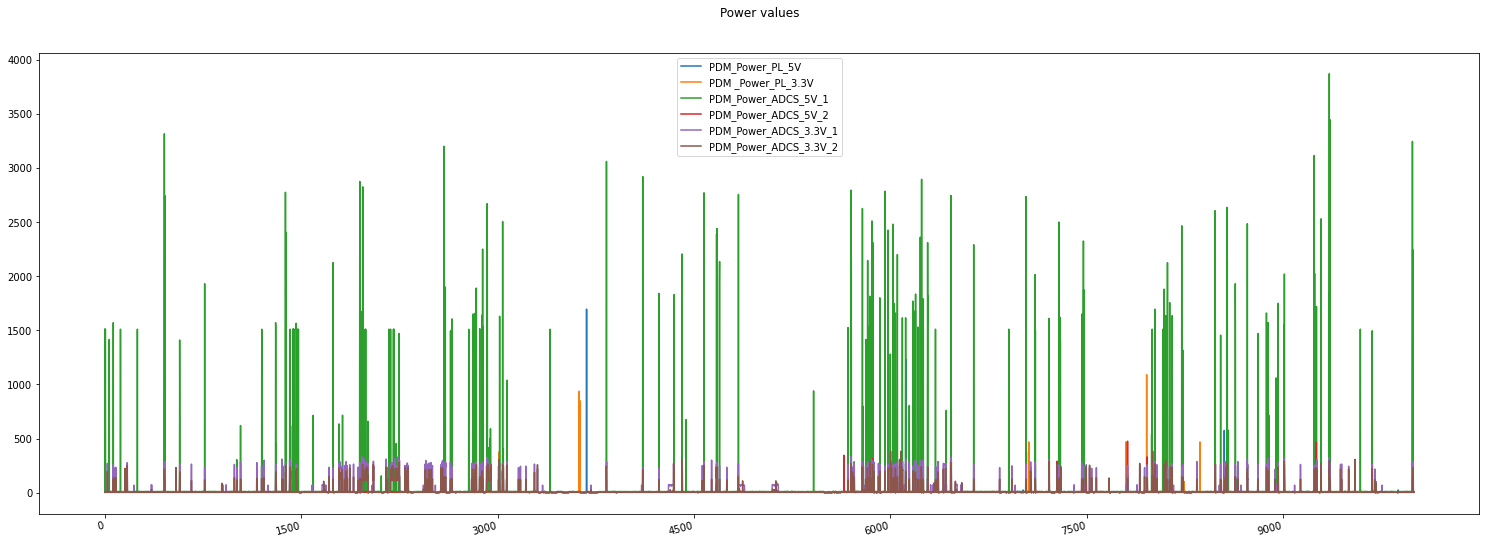

In [7]:
fig = plot( df.iloc[:10000],  "Power values", columns)
#save(fig, "../images/PDM_power_2.png")

## Create fake test data

## Preparing data for scalogram creation

In [7]:
step = 20
row_length = 40
test_size = 0.6
columns = ["PDM Power PL 5V", "PDM Power PL 3.3V","PDM Power ADCS 5V 1",
           "PDM Power ADCS 5V 2","PDM Power ADCS 3.3V 1", "PDM Power ADCS 3.3V 2"]

length = int(len(df)/step)*step
df_new = find_anomalies_std(df.iloc[-length:,:], columns)
df_new.reset_index(drop=True, inplace=True)
#plot( df_new,  "Power values", columns, anomalies=True)

<ipython-input-2-914b8779f5ef>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Anomaly"] = df_anomalies>=0.1*len(columns)
<ipython-input-2-914b8779f5ef>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Anomaly"] = df["Anomaly"].astype(int)


In [8]:
#X, Y =  get_sets(df_new, columns, step, row_length)
#data = wavelet_transformation(X, columns)
#x_train, x_test, y_train, y_test = train_test_split(data, Y, test_size=test_size, shuffle=False) 

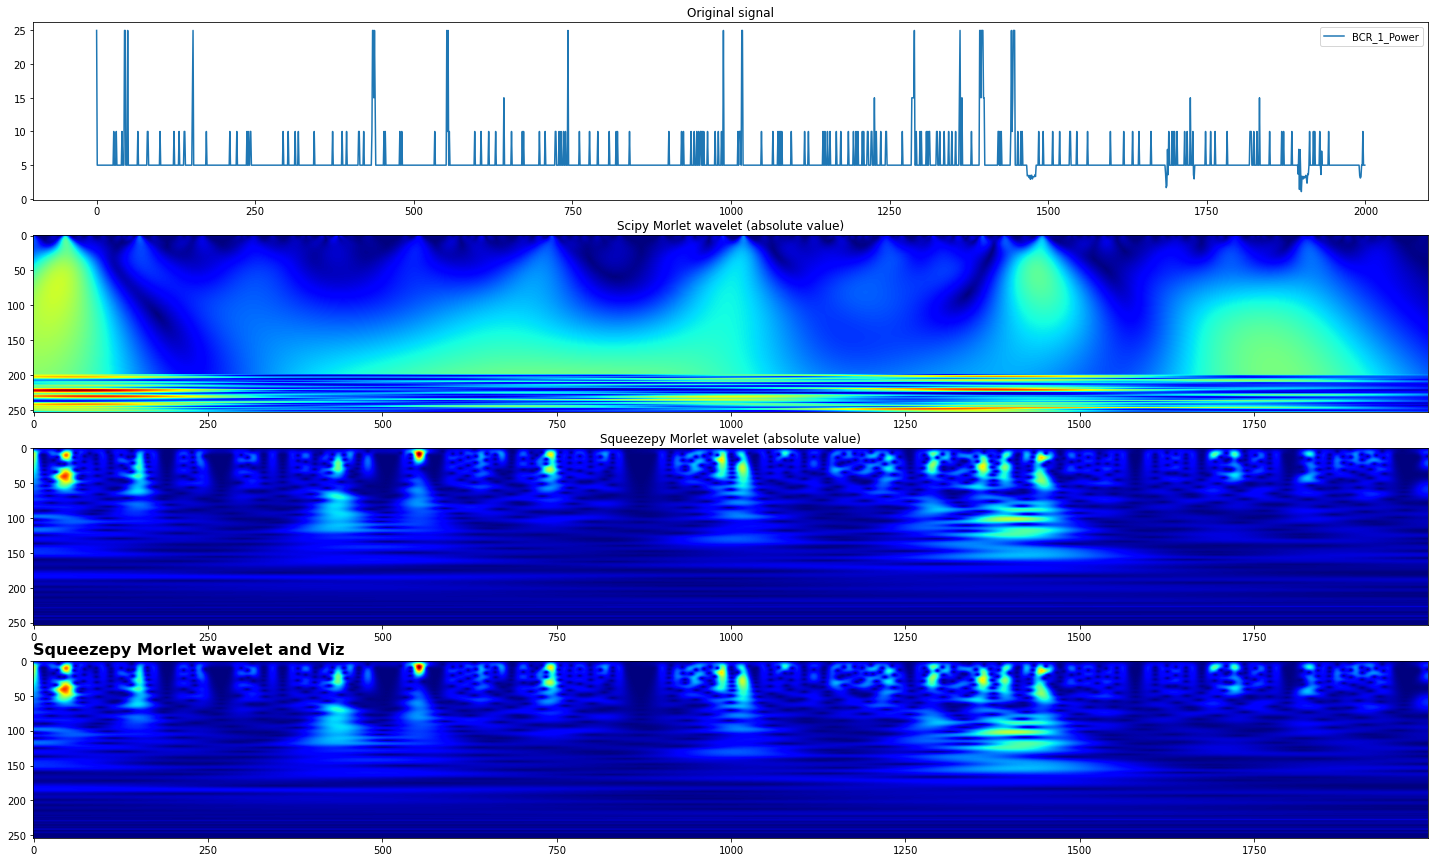

In [15]:
sig = df_new['PDM Power PL 5V'].iloc[:2000].values
Wx, scales = cwt(sig, 'morlet')
sig_rec = icwt(Wx,  wavelet='morlet')

widths = np.arange(1, 255)
cwtmatr = signal.cwt(sig, signal.morlet, widths)

fig, axs = plt.subplots(4)
fig.set_figheight(15)
fig.set_figwidth(25)

axs[0].plot(sig, label='BCR_1_Power')
axs[0].set_title("Original signal")
axs[0].legend()

axs[1].imshow(abs(cwtmatr), cmap='jet')
axs[1].set_title("Scipy Morlet wavelet (absolute value)")

axs[2].imshow(abs(Wx), cmap='jet')
axs[2].set_title("Squeezepy Morlet wavelet (absolute value)")

imshow(Wx, abs=1, show=1, ax=axs[3], title="Squeezepy Morlet wavelet and Viz")

#fig.savefig("../images/Wavelet_analysis/wavelet_comparison_morlet_3", facecolor='white', transparent=False)

## Preparing directories and saving scalograms

In [108]:
dataset_name = f'{"&".join(columns)}-{row_length}L{step}S{int(test_size*100)}T'
create_directory(dataset_name)

np.save(f'datasets/{dataset_name}/X.npy', X)
np.save(f'datasets/{dataset_name}/original_data.npy', df_new[columns+["Anomaly"]].values)
np.save(f'datasets/{dataset_name}/x_train.npy', x_train)
np.save(f'datasets/{dataset_name}/y_train.npy', y_train)
np.save(f'datasets/{dataset_name}/x_test.npy', x_test)
np.save(f'datasets/{dataset_name}/y_test.npy', y_test)

print("Save done")

Save done
